In [1]:
%load_ext autoreload
%autoreload 2
import sys, os
import glob
import numpy as np
import pandas as pd 
import nibabel as nib

from nilearn.input_data import NiftiMasker
from matplotlib import pyplot as plt
import seaborn as sns

from itertools import combinations_with_replacement, product
from scipy import stats

sys.path.append('../utils/') 

from config import *
import dataset_utils as utils
from tommy_utils import statistics, plotting, encoding, nlp

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /dartfs/rc/lab/F/FinnLab/tommy/models/token
Login successful


/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/dark_matter/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## Set paths to datasets

In [362]:
dataset = 'huth-moth'
task = 'wheretheressmoke' # only evaluate for one test task for now

results_dir = os.path.join(BASE_DIR, 'derivatives/results/', dataset) #, p.sub, p.model_name)
plots_dir = os.path.join(BASE_DIR, 'derivatives/plots/multiple-listen/', dataset, 'group')

utils.attempt_makedirs(plots_dir)

if dataset == 'deniz-readinglistening':
    data_dir = os.path.join(DATASETS_DIR, dataset, 'derivatives/dark-matter-preproc/')
else:
    data_dir = os.path.join(DATASETS_DIR, dataset, 'derivatives/dark-matter-preproc-smooth/')
    masks_dir = os.path.join(DATASETS_DIR, dataset, 'derivatives/masks/group/')
    mask_fn = os.path.join(masks_dir, 'group-MNI152NLin6Asym_res-all_desc-brain_gm-mask-intersection.nii.gz')
    masker = NiftiMasker(mask_fn).fit()

## Load run data

In [3]:
# get subjects excluding their html files
sub_dirs = sorted(glob.glob(os.path.join(data_dir, 'sub*[!html]')))
sub_list = [os.path.basename(d) for d in sub_dirs]

task_list = utils.DATASETS[dataset]['tasks']

In [4]:
run_nums = np.arange(2, 7)

all_sub_runs = utils.make_nested_dictionary()
dtypes = ['zscored', 'hyperaligned']

# load data for each run
for dtype, run in product(dtypes, run_nums):
    # put subjects together

    dss = []
    
    for sub in sub_list:
        print (f'{dtype} // run-{run} // {sub}')
        fns = sorted(glob.glob(os.path.join(data_dir, sub, f'*ses-{run}*{task}*{dtype}.npy')))
        ds = np.mean([np.load(fn) for fn in fns], axis=0)
        dss.append(ds)
    
    all_sub_runs[dtype][f'run-{run}'] = np.stack(dss)

zscored // run-2 // sub-UTS01
zscored // run-2 // sub-UTS02
zscored // run-2 // sub-UTS03
zscored // run-2 // sub-UTS04
zscored // run-2 // sub-UTS05
zscored // run-2 // sub-UTS06
zscored // run-2 // sub-UTS07
zscored // run-2 // sub-UTS08
zscored // run-3 // sub-UTS01
zscored // run-3 // sub-UTS02
zscored // run-3 // sub-UTS03
zscored // run-3 // sub-UTS04
zscored // run-3 // sub-UTS05
zscored // run-3 // sub-UTS06
zscored // run-3 // sub-UTS07
zscored // run-3 // sub-UTS08
zscored // run-4 // sub-UTS01
zscored // run-4 // sub-UTS02
zscored // run-4 // sub-UTS03
zscored // run-4 // sub-UTS04
zscored // run-4 // sub-UTS05
zscored // run-4 // sub-UTS06
zscored // run-4 // sub-UTS07
zscored // run-4 // sub-UTS08
zscored // run-5 // sub-UTS01
zscored // run-5 // sub-UTS02
zscored // run-5 // sub-UTS03
zscored // run-5 // sub-UTS04
zscored // run-5 // sub-UTS05
zscored // run-5 // sub-UTS06
zscored // run-5 // sub-UTS07
zscored // run-5 // sub-UTS08
zscored // run-6 // sub-UTS01
zscored //

## Calculate ISC for each run

In [5]:
def loo_isc(data):
	'''
	Calculate loo isc for a set of data
	data is assumed to be (n_subjects, n_TRs, n_voxels)
	'''
	
	all_results = np.ndarray((data.shape[0],data.shape[2]), dtype=float)
	all_subs = np.arange(data.shape[0])
	
	# hold out one subject; compare with average of remaining subjects
	for sub in all_subs:
		group = np.setdiff1d(all_subs, sub)
	
		# get subject data and rest of group average
		ds_sub = data[sub, ...]
		ds_group = np.mean(data[group, ...], axis=0)
		
		isc = statistics.array_correlation(ds_sub, ds_group)
		all_results[sub, ...] = isc

	return np.array(all_results)

In [223]:
# for through each datatype
all_loo_isc = utils.make_nested_dictionary()

all_means = utils.make_nested_dictionary()

for dtype in dtypes:

    all_run_means = []
    for run, dss in all_sub_runs[dtype].items():
        print (f'{dtype} // {run}')
        dss_isc = loo_isc(dss)
        all_loo_isc[dtype][run] = dss_isc
        all_run_means.append(ztransform_mean(dss_isc))
    
    all_means[dtype] = np.stack(all_run_means)
    

zscored // run-2


/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/dark_matter/lib/python3.9/site-packages/tommy_utils/statistics.py:72: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


zscored // run-3
zscored // run-4
zscored // run-5
zscored // run-6
hyperaligned // run-2
hyperaligned // run-3
hyperaligned // run-4
hyperaligned // run-5
hyperaligned // run-6


In [246]:
df_zscored = pd.DataFrame.from_dict(all_means['zscored'], orient='columns').T
df_zscored.columns = [f'run-{run-1}' for run in run_nums]
df_zscored['type'] = 'zscored'

df_ha = pd.DataFrame.from_dict(all_means['hyperaligned'], orient='columns').T
df_ha.columns = [f'run-{run-1}' for run in run_nums]
df_ha['type'] = 'hyperaligned'

# add together and collapse into run x type x isc
df_all = pd.concat([df_zscored, df_ha]).reset_index(drop=True)
df_all = pd.melt(df_all, id_vars=['type'], var_name='run', value_name='isc')

Text(0.5, 1.0, 'All voxel ISC declines across repeats')

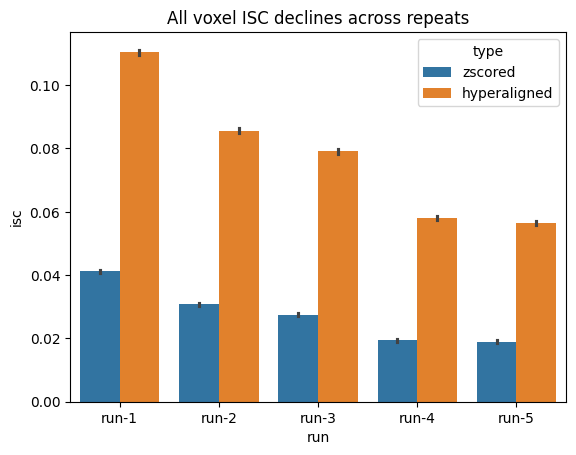

In [335]:
import seaborn as sns

sns.barplot(df_all, x='run', y='isc', hue='type')
plt.title(f'All voxel ISC declines across repeats')

### Brain plots of ISC for each run

In [349]:
zscored_diff = -1 * np.diff(all_means['zscored'], axis=0)
ha_diff = -1 * np.diff(all_means['hyperaligned'], axis=0)

In [373]:
cmap = 'RdBu_r'
vmax = np.nanmax([np.nanmax(abs(ha_diff)), np.nanmax(abs(zscored_diff))])

for dtype in dtypes:
    # diffs = -1 * np.diff(all_means[dtype], axis=0)
    for i, ds_run in enumerate(all_means[dtype][1:]): 
        
        ds = -1 * (np.arctanh(ds_run) - np.arctanh(all_means[dtype][0]))
        
        out_fn = os.path.join(plots_dir, f'group_multiple-listen-contrast_task-{task}_repeat-{i+1}_{dtype}.{EXT}')

        if dataset == 'deniz-readinglistening':
            surfs, data = plotting.numpy_to_surface(ds, target_density='41k')
        else:
            ds = masker.inverse_transform(ds)
            surfs, data = plotting.vol_to_surf(ds, surf_type='fsaverage', map_type='inflated')

        layer = plotting.make_layers_dict(data=data, cmap=cmap, label='Slope', alpha=1, color_range=(-vmax, vmax))
        
        _ = plotting.plot_surf_data(surfs, [layer], views=VIEWS, colorbar=True, surf_type=SURF_TYPE, 
            add_depth=ADD_DEPTH, out_fn=out_fn, title=f'Repeat {i+1} contrast - {dtype}')

Here
Here
Here
Here
Here
Here
Here
Here


## Find difference between subsequent runs

In [407]:
def ztransform_mean(dss, axis=0):
    return np.tanh(np.nanmean([np.arctanh(ds) for ds in dss], axis=axis))

In [367]:
all_runwise_diffs = utils.make_nested_dictionary()

# go through each run and compare it to the subsequent run
for dtype in dtypes:
    dss_diffs = []
    
    for run in run_nums[1:]:
        print (f'{dtype} // run-{run} v. run-{run_nums[0]}')

        # first is the first of the two numerically
        ds_first = all_loo_isc[dtype][f'run-{run_nums[0]}']
        ds_second = all_loo_isc[dtype][f'run-{run}']
    
        # positive values mean second run 
        ds_diff = np.tanh(np.arctanh(ds_second) - np.arctanh(ds_first))
        # ds_diff = ztransform_mean(dss_diff)

        dss_diffs.append(ds_diff)

    all_runwise_diffs[dtype] = np.stack(dss_diffs)

zscored // run-3 v. run-2
zscored // run-4 v. run-2
zscored // run-5 v. run-2
zscored // run-6 v. run-2
hyperaligned // run-3 v. run-2
hyperaligned // run-4 v. run-2
hyperaligned // run-5 v. run-2
hyperaligned // run-6 v. run-2


In [660]:
run_ratios = np.arctanh(all_runwise_diffs['hyperaligned']) / abs(np.arctanh(all_runwise_diffs['zscored']))
# run_ratios = np.moveaxis(run_ratios, 0, 1)

run_ratios = run_ratios / np.nanstd(run_ratios, axis=0)#[:, np.newaxis, :]

run_ratios = np.moveaxis(run_ratios, 0, 1)
# average across subjects
# run_ratios = np.nanmedian(run_ratios, axis=1)

run_ratios = np.nanmean(run_ratios, axis=0)

/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/dark_matter/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0.5, 1.0, 'Dissimilarity ratio -- single voxel ISC')

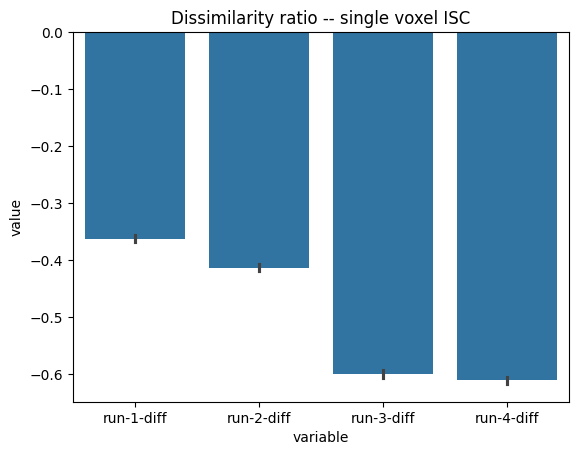

In [661]:
df_ratios = pd.DataFrame(run_ratios).T
df_ratios.columns = [f'run-{run-1}-diff' for run in run_nums[:-1]]

df_ratios = pd.melt(df_ratios).dropna()
sns.barplot(df_ratios, x='variable', y='value')

plt.title('Dissimilarity ratio -- single voxel ISC')

In [639]:
runs = run_nums[:-1]
all_slopes = []

for ds_sub in run_ratios:
    sub_slopes = []
    for vox in ds_sub.T:
        slope, intercept, r_value, p_value, std_err = stats.linregress(runs, vox)
        sub_slopes.append(slope)
    all_slopes.append(np.stack(sub_slopes))

slopes = np.mean(np.stack(all_slopes), axis=0)

In [652]:
# Fit a linear polynomial to the data
runs = run_nums[:-1]
# runs = np.tile(run_nums[:-1], len(sub_list))

# x, y, z = run_ratios.shape
# run_ratios = run_ratios.reshape(x*y, z)

results = []
for i, vox in enumerate(run_ratios.T):
    slope, intercept, r_value, p_value, std_err = stats.linregress(runs, vox)
    results.append(np.array([slope, r_value, p_value]))

In [657]:
slopes, rvals, pvals = np.stack(results).T

Here


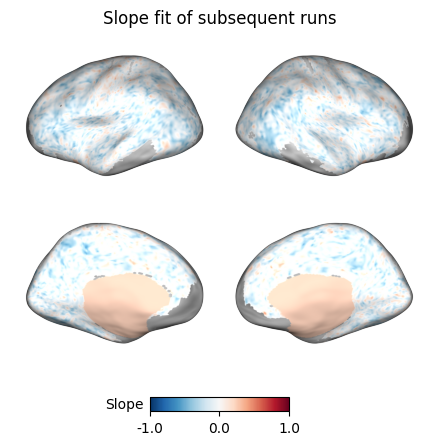

In [662]:
# slopes[p_vals>=0.05] = 0
ds = slopes
cmap = 'RdBu_r'

vmax = 1 #np.nanmax(abs(ds)) #np.nanmax(abs(ds))

# out_fn = os.path.join(plots_dir, f'group_listening-reading-contrast_all-tasks_loo-isc.{EXT}')

if dataset == 'deniz-readinglistening':
    surfs, data = plotting.numpy_to_surface(ds, target_density='41k')
else:
    ds = masker.inverse_transform(ds)
    surfs, data = plotting.vol_to_surf(ds, surf_type='fsaverage', map_type='inflated', method='linear')

layer = plotting.make_layers_dict(data=data, cmap=cmap, label='Slope', alpha=1, color_range=(-vmax, vmax))

_ = plotting.plot_surf_data(surfs, [layer], views=VIEWS, colorbar=True, surf_type=SURF_TYPE, 
    add_depth=ADD_DEPTH, embed_nb=True, title='Slope fit of subsequent runs')